### Windowed Accuracy Analysis: Static, Batch, and Online Models

This notebook demonstrates a comparative analysis of **Static**, **Batch**, and **Online Incremental Learning** models in evolving data environments. By evaluating their performance on a **windowed accuracy metric**, we aim to understand how these models handle dynamic data streams and adapt to **concept drift**.

Key aspects covered in this notebook:
- **Windowed Accuracy Evaluation**: Comparing the accuracy of models over sliding windows of data, highlighting their ability to maintain performance over time.
- **Concept Drift Adaptation**: Analyzing how each model responds to shifts in data distribution.
- **Static vs. Batch vs. Online Models**: Demonstrating the limitations of static models, the partial recovery of batch models, and the rapid adaptability of online models.

The included visualizations and metrics highlight how online models outperform static and batch approaches in maintaining accuracy and adapting to changing data patterns.

In [ ]:
!pip install turboml-installer 
import turboml_installer ; turboml_installer.install_on_colab()

Cloning into 'colab-notebooks'...
remote: Enumerating objects: 419, done.
remote: Counting objects: 100% (419/419), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 419 (delta 334), reused 363 (delta 285), pack-reused 0 (from 0)
Receiving objects: 100% (419/419), 15.12 MiB | 6.29 MiB/s, done.
Resolving deltas: 100% (334/334), done.


In [1]:
! pip install -U kaleido plotly

In [2]:
## Replace this connection details by signing into turboml.com ##
import turboml as tb
tb.init(backend_url=BACKEND_URL, api_key=API_KEY)
#################################################################

In [3]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from turboml.common.models import InputSpec
from tqdm import tqdm

pio.kaleido.scope.default_format = "svg"

In [4]:
# You can replace this with any other csv file that you wish to be read
CSV_DATA_PATH = 'https://github.com/songqiaohu/THU-Concept-Drift-Datasets-v1.0/raw/refs/heads/main/Datasets_in_CADM+/LSudden_3.csv'
df = pd.read_csv(CSV_DATA_PATH)
df.head(10)

,x1,x2,x3,x4,x5,label
0,-6.481079,-6.242985,-9.531891,-6.968090,0.907054,1
1,5.042903,10.506421,2.528749,4.815682,-2.993558,0
2,2.173806,5.376893,6.429978,8.943717,-3.312305,1
3,8.696228,-13.301626,6.950536,-3.641624,4.728401,2
4,-11.403451,1.739396,-9.612974,-5.025895,7.536184,0
5,-1.517938,3.653680,-9.531835,7.654967,-3.506054,0
6,3.783037,-2.664017,-5.322132,0.983280,-4.604893,2
7,-5.280508,-6.294126,-8.153463,2.830699,-3.972099,1
8,2.525642,1.649270,6.150019,-9.985133,3.025769,1
9,6.168740,-0.663412,9.400588,-0.037433,-6.965257,2


In [5]:
COLS = [f'f{i}' for i in range(len(df.columns)-1)] + ['label']
df.columns = COLS # renaming the columns as 'f1, f2, ..., label
df['label'] = pd.factorize(df['label'])[0] # mapping the categorical labels from 0, 1, 2 and so on...
df.describe()

,f0,f1,f2,f3,f4,label
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,0.002237,0.009549,0.000516,-0.000290,-0.003329,1.090531
std,8.659195,8.656719,5.768471,5.775230,5.779969,0.792733
min,-14.999979,-14.999970,-9.999994,-10.000000,-9.999982,0.000000
25%,-7.496444,-7.484103,-4.982924,-5.001308,-5.013451,0.000000
50%,0.005781,0.015272,-0.000886,-0.003483,0.003715,1.000000
75%,7.504715,7.510526,4.991598,5.000339,4.997230,2.000000
max,14.999997,14.999936,9.999973,9.999987,9.999997,2.000000


In [6]:
stream = df[COLS[:-1]].reset_index()
labels = df[COLS[-1]].astype(int).reset_index()
NUM_CLASSES = df[COLS[-1]].nunique()
print(len(stream))
stream.info()

1000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   index   1000000 non-null  int64  
 1   f0      1000000 non-null  float64
 2   f1      1000000 non-null  float64
 3   f2      1000000 non-null  float64
 4   f3      1000000 non-null  float64
 5   f4      1000000 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 45.8 MB


# **Data Division**

We split our data into multiple parts for our demonstration, set the `NUM_PARTS` variable to the number of parts you want the data to be divided into.

For our demonstration we will use these parts for `static`, `batch` and `online` processing and evaluation.

In [7]:
NUM_PARTS = 10

# Split both the features (stream) and the labels dataframe into NUM_PARTS parts
data_parts = np.array_split(stream, NUM_PARTS)
label_parts = np.array_split(labels, NUM_PARTS)

# 'data_parts' and 'label_parts' are lists of pandas DataFrames
for i, (data_part, label_part) in enumerate(zip(data_parts, label_parts)):
    print(f"Part {i+1} - Features Rows: {len(data_part)}, Labels Rows: {len(label_part)}")

Part 1 - Features Rows: 100000, Labels Rows: 100000
Part 2 - Features Rows: 100000, Labels Rows: 100000
Part 3 - Features Rows: 100000, Labels Rows: 100000
Part 4 - Features Rows: 100000, Labels Rows: 100000
Part 5 - Features Rows: 100000, Labels Rows: 100000
Part 6 - Features Rows: 100000, Labels Rows: 100000
Part 7 - Features Rows: 100000, Labels Rows: 100000
Part 8 - Features Rows: 100000, Labels Rows: 100000
Part 9 - Features Rows: 100000, Labels Rows: 100000
Part 10 - Features Rows: 100000, Labels Rows: 100000


/usr/local/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning:

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.



### **Windowed Metric Calculation Function**

This function is defined for calculating the accuracy, f1 score and the roc_auc score in a windowed manner, where the `window_size` and the `step_size` are passed into the parameters.

In [8]:
# Function to calculate windowed metrics
def calculate_windowed_metric(predictions, labels, window_size, step_size=1, metric='accuracy'):
    metrics = []
    num_steps = (len(predictions) - window_size) // step_size + 1

    for i in tqdm(range(num_steps)):
        start = i * step_size
        end = start + window_size
        if end > len(predictions):
            break

        # Calculate the chosen metric
        if metric == 'accuracy':
            score = accuracy_score(labels[start:end], predictions[start:end])
        elif metric == 'f1':
            score = f1_score(labels[start:end], predictions[start:end], average='weighted')
        elif metric == 'roc_auc':
            try:
                score = roc_auc_score(labels[start:end], predictions[start:end])
            except ValueError:
                score = None  # In case of only one class present in this window
        else:
            raise ValueError("Unsupported metric. Choose 'accuracy', 'f1', or 'roc_auc'.")

        # Append score if valid
        if score is not None:
            metrics.append(score)

    return metrics


In [9]:
# preparing the input specification for the Local Models
numerical_fields = ['f0', 'f1', 'f2', 'f3', 'f4']

input_spec = InputSpec(
    key_field='index',
    numerical_fields=numerical_fields,
    categorical_fields=[],
    textual_fields=[],
    imaginal_fields=[],
    time_field="",
    label_field='label'
    )

## **Static Model**

In this part we train the static model, which will be used to show the "control" part of demonstration. This model will be used to demonstrate the performance **without re-training** on the newer data.

For our demonstration we will be using the Hoeffding Tree Classifier `tb.HoeffdingTreeClassifier`. You can refer to the documentation and use other classifiers as well.

### **Static Model Benchmarking**
The benchmarking of the static model takes place only by training on an initial set of data, without retraining on the new data and just calculating the predictions

100%|██████████| 896/896 [00:00<00:00, 1181.21it/s]


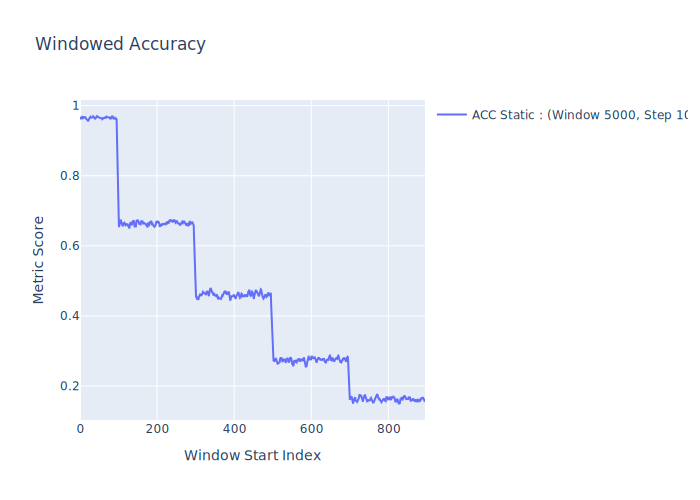

In [12]:
# initial static model training
input_data = tb.LocalDataset.from_pd(
  df=data_parts[0],
  key_field="index"
).get_model_inputs(numerical_fields = numerical_fields)

label_data = tb.LocalDataset.from_pd(
  df=label_parts[0],
  key_field="index"
).get_model_labels(label_field='label')

static_model = tb.HoeffdingTreeClassifier(n_classes=NUM_CLASSES)
static_model_local = static_model.to_local_model(input_spec)

static_model_local.learn(input_data, label_data)

# static model benchmarking
all_static_predictions = []
all_labels = []

for i in tqdm(range(NUM_PARTS-1)):
    part_id_ = i + 1
    df_part_ = data_parts[part_id_]
    labels_part_ = label_parts[part_id_]

    input_data = tb.LocalDataset.from_pd(
        df=df_part_,
        key_field="index",
    ).get_model_inputs(numerical_fields = numerical_fields)

    label_data = tb.LocalDataset.from_pd(
        df=labels_part_,
        key_field="index"
    ).get_model_labels(label_field='label')

    part_labels_df = labels_part_
    all_labels.extend(part_labels_df['label'].tolist())

    all_static_predictions.extend(static_model_local.predict(input_data)['predicted_class'].tolist())

merged_labels = pd.concat([label_parts[i].reset_index() for i in range(1, 10)], ignore_index=True)

merged_static_predictions = pd.DataFrame({'predicted_class': all_static_predictions})

merged_labels = pd.DataFrame({'label': all_labels})

windowed_metrics_static = calculate_windowed_metric(
    merged_static_predictions['predicted_class'],
    merged_labels['label'],
    window_size=5000,
    step_size=1000,
    metric='accuracy'
)

fig = go.Figure()

fig.add_trace(go.Scatter(
    y=windowed_metrics_static,
    mode='lines',
    name='ACC Static : (Window 5000, Step 1000)'
))

fig.update_layout(
    title='Windowed Accuracy',
    xaxis_title='Window Start Index',
    yaxis_title='Metric Score',
    showlegend=True,
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True)
)

fig.show("svg")

### **Analysis of the results of Static Model**
From the above results we can easily infer that because there was no re-training the model's performance becomes poor at every point where concept drift occurs.

### **Batch Model Benchmarking**
In batch model's benchmarking, we have the initial trained model then we re-train the model after a set large enough batch size.

100%|██████████| 896/896 [00:01<00:00, 824.03it/s]


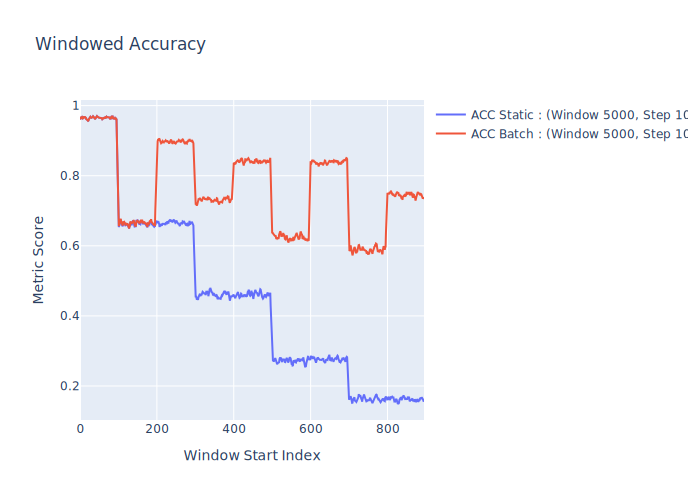

In [14]:
# initial batch model training
input_data = tb.LocalDataset.from_pd(
  df=data_parts[0],
  key_field="index"
).get_model_inputs(numerical_fields = numerical_fields)

label_data = tb.LocalDataset.from_pd(
  df=label_parts[0],
  key_field="index"
).get_model_labels(label_field='label')

batch_model = tb.HoeffdingTreeClassifier(n_classes=NUM_CLASSES)
batch_model_local = batch_model.to_local_model(input_spec)

batch_model_local.learn(input_data, label_data)

# batch model benchmarking
all_batch_predictions = []
all_batch_labels = []

for i in tqdm(range(NUM_PARTS-1)):
    part_id_ = i + 1
    df_part_ = data_parts[part_id_]
    labels_part_ = label_parts[part_id_]

    input_data = tb.LocalDataset.from_pd(
        df=df_part_,
        key_field="index",
    ).get_model_inputs(numerical_fields = numerical_fields)

    label_data = tb.LocalDataset.from_pd(
        df=labels_part_,
        key_field="index"
    ).get_model_labels(label_field='label')

    part_labels_df = labels_part_
    all_labels.extend(part_labels_df['label'].tolist())

    all_batch_predictions.extend(batch_model_local.predict(input_data)['predicted_class'].tolist())
    all_batch_labels.extend(part_labels_df['label'].tolist())

    batch_model_local.learn(input_data, label_data)

merged_batch_predictions = pd.DataFrame({'predicted_class': all_batch_predictions})
merged_batch_labels = pd.DataFrame({'label': all_batch_labels})

windowed_metrics_batch = calculate_windowed_metric(
    merged_batch_predictions['predicted_class'],
    merged_batch_labels['label'],
    window_size=5000,
    step_size=1000,
    metric='accuracy'
)

fig = go.Figure()

# Add ACC Static line
fig.add_trace(go.Scatter(
    y=windowed_metrics_static,
    mode='lines',
    name='ACC Static : (Window 5000, Step 1000)'
))

# Add ACC Batch line
fig.add_trace(go.Scatter(
    y=windowed_metrics_batch,
    mode='lines',
    name='ACC Batch : (Window 5000, Step 1000)'
))

# Update layout with labels, title, and gridlines
fig.update_layout(
    title='Windowed Accuracy',
    xaxis_title='Window Start Index',
    yaxis_title='Metric Score',
    showlegend=True,
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True)
)

fig.show("svg")

### **Analysis and Comparison of Batch-Wise Retraining**

From the above results, we can see that batch-wise re-training does improve the performance during concept drift and overall shows a better performance as compared to the static model.

### **Online Model Benchmarking**
In an online model's benchmarking we wish to have online learning, that is, the model trains on every new data point that it encounters. However in our benchmark below we will use a very small batch - which will simulate the online learning scenario to some extent, we do this to save time while running this notebook.

100%|██████████| 896/896 [00:01<00:00, 794.20it/s]


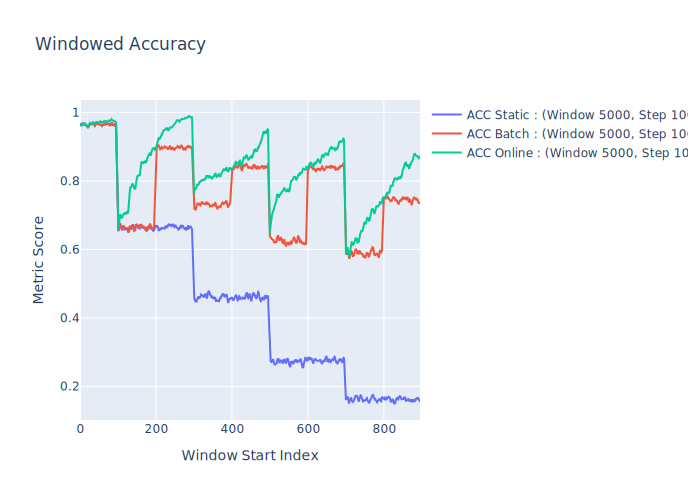

In [15]:
# initial batch model training
input_data = tb.LocalDataset.from_pd(
  df=data_parts[0],
  key_field="index"
).get_model_inputs(numerical_fields = numerical_fields)

label_data = tb.LocalDataset.from_pd(
  df=label_parts[0],
  key_field="index"
).get_model_labels(label_field='label')

online_model = tb.HoeffdingTreeClassifier(n_classes=NUM_CLASSES)
online_model_local = online_model.to_local_model(input_spec)

online_model_local.learn(input_data, label_data)

# online model benchmarking
all_online_predictions = []
ONLINE_TRAIN_STREAM_SIZE = 1000
merged_data = pd.concat([data_parts[i].reset_index() for i in range(1, 10)], ignore_index=True)
merged_labels = pd.concat([label_parts[i].reset_index() for i in range(1, 10)], ignore_index=True)
num_batches = len(merged_data) // ONLINE_TRAIN_STREAM_SIZE

all_online_labels = []

for batch_index in tqdm(range(num_batches)):
    # Get the current batch of data and labels
    start_idx = batch_index * ONLINE_TRAIN_STREAM_SIZE
    end_idx = start_idx + ONLINE_TRAIN_STREAM_SIZE
    batch_data = merged_data.iloc[start_idx:end_idx]
    batch_labels = merged_labels.iloc[start_idx:end_idx]
    
    stream_data = tb.LocalDataset.from_pd(
        df=batch_data,
        key_field="index"
    ).get_model_inputs(numerical_fields = numerical_fields)

    stream_labels = tb.LocalDataset.from_pd(
        df=batch_labels,
        key_field="index"
    ).get_model_labels(label_field='label')

    # Store predictions and labels
    all_online_predictions.extend(online_model_local.predict(stream_data)['predicted_class'].tolist())
    all_online_labels.extend(batch_labels['label'].tolist())

    # Update the model with the current small batch(stream) (online learning)
    online_model_local.learn(stream_data, stream_labels)

merged_online_predictions = pd.DataFrame({'predicted_class': all_online_predictions})
merged_online_labels = pd.DataFrame({'label': all_online_labels})

windowed_metrics_online = calculate_windowed_metric(
    merged_online_predictions['predicted_class'],
    merged_online_labels['label'],
    window_size=5000,
    step_size=1000,
    metric='accuracy'
)

fig = go.Figure()

fig.add_trace(go.Scatter(
    y=windowed_metrics_static,
    mode='lines',
    name='ACC Static : (Window 5000, Step 1000)'
))
fig.add_trace(go.Scatter(
    y=windowed_metrics_batch,
    mode='lines',
    name='ACC Batch : (Window 5000, Step 1000)'
))
fig.add_trace(go.Scatter(
    y=windowed_metrics_online,
    mode='lines',
    name='ACC Online : (Window 5000, Step 1000)'
))

fig.update_layout(
    title='Windowed Accuracy',
    xaxis_title='Window Start Index',
    yaxis_title='Metric Score',
    showlegend=True,
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True)
)

fig.show("svg")

# cleanup
del online_model_local, batch_model_local, static_model_local

### **Analysis and Comparison of Online Learning Method**
As we can see the regular updates of the model results in a much better performance as compared to the both the static and the batch-wise re-training methods.

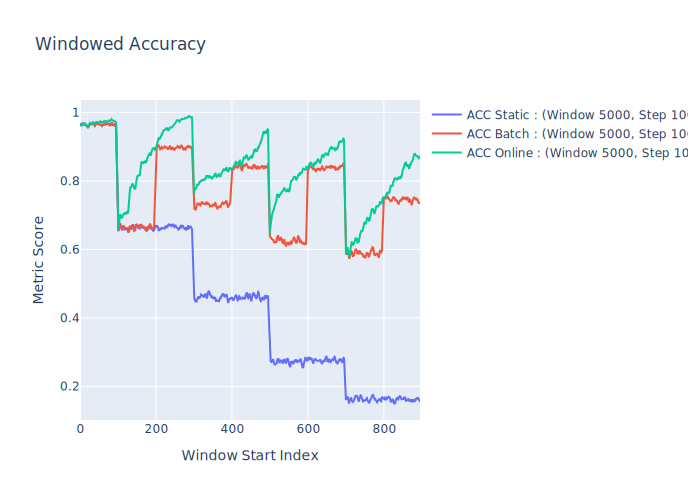

In [16]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    y=windowed_metrics_static,
    mode='lines',
    name='ACC Static : (Window 5000, Step 1000)'
))
fig.add_trace(go.Scatter(
    y=windowed_metrics_batch,
    mode='lines',
    name='ACC Batch : (Window 5000, Step 1000)'
))
fig.add_trace(go.Scatter(
    y=windowed_metrics_online,
    mode='lines',
    name='ACC Online : (Window 5000, Step 1000)'
))

fig.update_layout(
    title='Windowed Accuracy',
    xaxis_title='Window Start Index',
    yaxis_title='Metric Score',
    showlegend=True,
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True)
)

fig.show("svg")

### **Do it Yourself**

Now you can use the function below to change the `stream_size` and check the performance comparison with the static and the batch model

100%|██████████| 896/896 [00:00<00:00, 1158.26it/s]


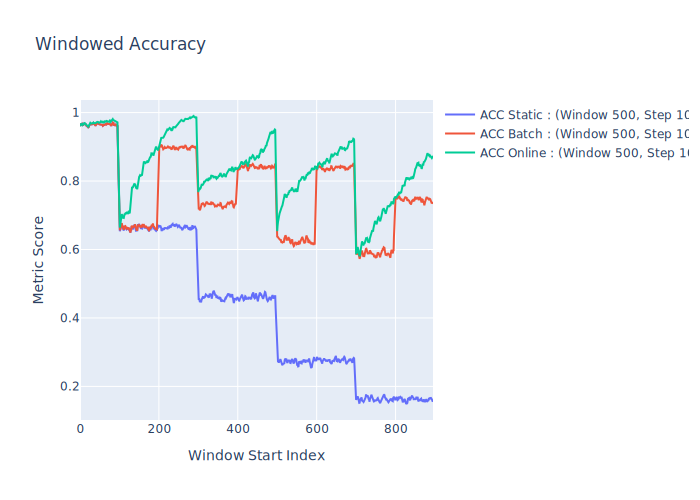

In [17]:
def online_benchmarking(stream_size=1000, window_size=5000, step_size=1000):
    global data_parts, label_parts, numerical_fields, input_spec, NUM_CLASSES
    # initial batch model training
    input_data = tb.LocalDataset.from_pd(
    df=data_parts[0],
    key_field="index"
    ).get_model_inputs(numerical_fields = numerical_fields)

    label_data = tb.LocalDataset.from_pd(
    df=label_parts[0],
    key_field="index"
    ).get_model_labels(label_field='label')

    model = tb.HoeffdingTreeClassifier(n_classes=NUM_CLASSES)
    model_local = model.to_local_model(input_spec)

    model_local.learn(input_data, label_data)

    # online model benchmarking
    all_online_predictions = []
    ONLINE_TRAIN_STREAM_SIZE = stream_size
    merged_data = pd.concat([data_parts[i].reset_index() for i in range(1, 10)], ignore_index=True)
    merged_labels = pd.concat([label_parts[i].reset_index() for i in range(1, 10)], ignore_index=True)
    num_batches = len(merged_data) // ONLINE_TRAIN_STREAM_SIZE

    all_online_labels = []

    for batch_index in tqdm(range(num_batches)):
        # Get the current batch of data and labels
        start_idx = batch_index * ONLINE_TRAIN_STREAM_SIZE
        end_idx = start_idx + ONLINE_TRAIN_STREAM_SIZE
        batch_data = merged_data.iloc[start_idx:end_idx]
        batch_labels = merged_labels.iloc[start_idx:end_idx]
        
        stream_data = tb.LocalDataset.from_pd(
            df=batch_data,
            key_field="index"
        ).get_model_inputs(numerical_fields = numerical_fields)

        stream_labels = tb.LocalDataset.from_pd(
            df=batch_labels,
            key_field="index"
        ).get_model_labels(label_field='label')

        # Store predictions and labels
        all_online_predictions.extend(model_local.predict(stream_data)['predicted_class'].tolist())
        all_online_labels.extend(batch_labels['label'].tolist())

        # Update the model with the current small batch(stream) (online learning)
        model_local.learn(stream_data, stream_labels)

    merged_online_predictions = pd.DataFrame({'predicted_class': all_online_predictions})
    merged_online_labels = pd.DataFrame({'label': all_online_labels})

    windowed_metrics_static = calculate_windowed_metric(
        merged_static_predictions['predicted_class'],
        merged_labels['label'],
        window_size=5000,
        step_size=1000,
        metric='accuracy'
    )

    windowed_metrics_batch = calculate_windowed_metric(
        merged_batch_predictions['predicted_class'],
        merged_batch_labels['label'],
        window_size=5000,
        step_size=1000,
        metric='accuracy'
    )

    windowed_metrics_online = calculate_windowed_metric(
        merged_online_predictions['predicted_class'],
        merged_online_labels['label'],
        window_size=5000,
        step_size=1000,
        metric='accuracy'
    )

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        y=windowed_metrics_static,
        mode='lines',
        name=f'ACC Static : (Window {window_size}, Step {step_size})'
    ))
    fig.add_trace(go.Scatter(
        y=windowed_metrics_batch,
        mode='lines',
        name=f'ACC Batch : (Window {window_size}, Step {step_size})'
    ))
    fig.add_trace(go.Scatter(
        y=windowed_metrics_online,
        mode='lines',
        name=f'ACC Online : (Window {window_size}, Step {step_size})'
    ))

    fig.update_layout(
        title='Windowed Accuracy',
        xaxis_title='Window Start Index',
        yaxis_title='Metric Score',
        showlegend=True,
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True)
    )

    fig.show("svg")

# you can use the above function to try out the online model with different stream sizes, window_size and step_size
online_benchmarking(stream_size=100, window_size=500, step_size=100)